In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

from gluoncv.data import CitySegmentation

%matplotlib inline

Using TensorFlow backend.
/home/ruslan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ruslan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ruslan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ruslan/.local/lib/python3.6/site-packages/tensorflow/python

Prepare Cityscapes dataset.
========================
The dataset focuses on semantic understanding of urban street scenes. Execute the next script in order to download and prepare the dataset

In [2]:
#! cityscapes/prepare_cityscapes.sh

In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [4]:
# classes for data loading and preprocessing
class Dataset:
    """CityScapes Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        labels (str): one of 'train' or 'val'
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['unlabeled', 'ego vehicle', 'rectification border', 'out of roi', 'static', 'dynamic',
               'ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence',
               'guard rail', 'bridge', 'tunnel', 'pole', 'polegroup', 'traffic light', 'traffic sign',
               'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'caravan',
               'trailer', 'train', 'motorcycle', 'bicycle', 'license plate']
    
    def __init__(self, label, classes=None, augmentation=None, preprocessing=None):
        self.gluoncv_dataset = CitySegmentation(split=label)
        self.images_fps = self.gluoncv_dataset.images
        self.masks_fps = self.gluoncv_dataset.mask_paths
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_fps)

Dataloader and utility functions
------------------------




In [5]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

Found 2975 images in the folder /home/ruslan/.mxnet/datasets/citys/leftImg8bit/train


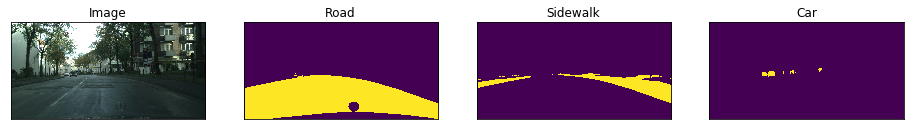

In [6]:
CLASSES = ['road', 'sidewalk', 'car', ]

dataset = Dataset('train', classes=CLASSES)

image, mask = dataset[1] # get some sample

visualize(
    image=image, 
    road=mask[..., 0].squeeze(),
    sidewalk=mask[..., 1].squeeze(),
    car=mask[..., 2].squeeze(),
)

Found 500 images in the folder /home/ruslan/.mxnet/datasets/citys/leftImg8bit/val


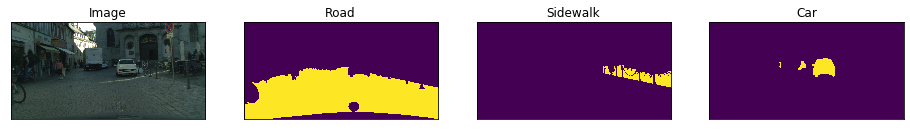

In [7]:
CLASSES = ['road', 'sidewalk', 'car', ]

dataset = Dataset('val', classes=CLASSES)

image, mask = dataset[1] # get some sample

visualize(
    image=image, 
    road=mask[..., 0].squeeze(),
    sidewalk=mask[..., 1].squeeze(),
    car=mask[..., 2].squeeze(),
)

# Data augmentation

In [8]:
import albumentations as A

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_heavy_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=512, min_width=1024, always_apply=True, border_mode=0),
        A.RandomCrop(height=512, width=1024, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

def get_training_augmentation():
    train_transform = [
        A.PadIfNeeded(min_height=512, min_width=1024, always_apply=True, border_mode=0),
        A.RandomCrop(height=512, width=1024, always_apply=True),
    ]
    return A.Compose(train_transform)


def get_validation_augmentation(w=512, h=1024):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(w, h)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

Found 2975 images in the folder /home/ruslan/.mxnet/datasets/citys/leftImg8bit/train


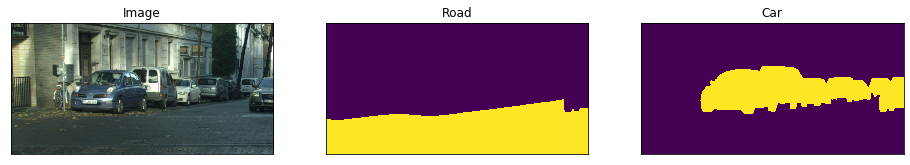

In [9]:
# Lets look at augmented data we have
aug_dataset = Dataset('train', classes=['road', 'car'], augmentation=get_training_augmentation())

image, mask = aug_dataset[4] # get some sample
visualize(
    image=image, 
    road=mask[..., 0].squeeze(),
    car=mask[..., 1].squeeze(),
)

# Segmentation model training

In [10]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [11]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 1
CLASSES = ['road', 'sidewalk', 'building',
           'traffic light', 'traffic sign',
           'vegetation', 'person', 'car']
CLASS_WEIGHTS = np.array([2, 2, 1, 2, 2, 1, 2, 2, 0.5]) # last weight is added for backgound (0.5)
# CLASSES = ['road', 'car']
# CLASS_WEIGHTS = np.array([2, 2, 0.5]) # last weight is added for backgound (0.5)
LR = 0.001
EPOCHS = 100

preprocess_input = sm.get_preprocessing(BACKBONE)

In [12]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [13]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (for example, car: 1.; person: 2.; sky: 0.5;)

dice_loss = sm.losses.DiceLoss(class_weights=CLASS_WEIGHTS) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [14]:
# Dataset for train images
train_dataset = Dataset(
    label='train', 
    classes=CLASSES, 
    augmentation=get_heavy_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    label='val', 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 1024, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 1024, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

/home/ruslan/.local/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2875: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


Found 2975 images in the folder /home/ruslan/.mxnet/datasets/citys/leftImg8bit/train
Found 500 images in the folder /home/ruslan/.mxnet/datasets/citys/leftImg8bit/val


In [15]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100
2975/2975 [==============================] - 1143s 384ms/step - loss: 0.7988 - iou_score: 0.2952 - f1-score: 0.3638 - val_loss: 0.9006 - val_iou_score: 0.2822 - val_f1-score: 0.3894
Epoch 2/100
2975/2975 [==============================] - 1109s 373ms/step - loss: 0.5881 - iou_score: 0.3450 - f1-score: 0.4250 - val_loss: 0.5772 - val_iou_score: 0.3378 - val_f1-score: 0.4410
Epoch 3/100
2975/2975 [==============================] - 1109s 373ms/step - loss: 0.5210 - iou_score: 0.3795 - f1-score: 0.4595 - val_loss: 0.4247 - val_iou_score: 0.3618 - val_f1-score: 0.4775
Epoch 4/100
2975/2975 [==============================] - 1118s 376ms/step - loss: 0.4809 - iou_score: 0.4062 - f1-score: 0.4868 - val_loss: 0.2440 - val_iou_score: 0.4782 - val_f1-score: 0.5924
Epoch 5/100
2975/2975 [==============================] - 1118s 376ms/step - loss: 0.4578 - iou_score: 0.4136 - f1-score: 0.4935 -

KeyboardInterrupt: 

# Model evaluation

In [1]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
# load best weights
model.load_weights('trained_models/unet_cityscapes_40epochs.h5')

In [16]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))


Loss: -0.092553
mean iou_score: 0.63874
mean f1-score: 0.73497


### Test on sequence of images

In [16]:
def seglayers2mask(image, output, random_colors=True):
    # infer the total number of classes along with the spatial dimensions
    # of the mask image via the shape of the output array
    (height, width, numClasses) = output.shape[1:4]
    # print("[INFO] Number of classes: {:d}".format(numClasses))

    # our output class ID map will be num_classes x height x width in
    # size, so we take the argmax to find the class label with the
    # largest probability for each and every (x, y)-coordinate in the
    # image
    classMap = np.argmax(output[0], axis=-1)

    # given the class ID map, we can map each of the class IDs to its
    # corresponding color
    if random_colors:
        np.random.seed(12)
        COLORS = np.random.randint(0, 255, size=(numClasses-1, 3), dtype="uint8")
        COLORS = np.vstack([COLORS, [0, 0, 0]]).astype("uint8")
    else:
        COLORS = open('colors.txt').read().strip().split("\n")
        COLORS = [np.array(c.split(",")).astype("int") for c in COLORS]
        COLORS = np.array(COLORS, dtype="uint8")
    
    mask = COLORS[classMap]

    # resize the mask and class map such that its dimensions match the
    # original size of the input image (we're not using the class map
    # here for anything else but this is how you would resize it just in
    # case you wanted to extract specific pixels/classes)
    mask = cv2.resize(mask, (image.shape[2], image.shape[1]), interpolation=cv2.INTER_NEAREST)
    # classMap = cv2.resize(classMap, (image.shape[2], image.shape[1]), interpolation=cv2.INTER_NEAREST)

    # perform a weighted combination of the input image with the mask to
    # form an output visualization
    rescaled_image = image[0] - np.min(image[0])
    rescaled_image /= np.max(rescaled_image)
    rescaled_image *= 255 # resaled image has color values in range 0..255
    output = ((0.4 * rescaled_image) + (0.6 * mask)).astype("uint8")# mask.astype("uint8")
    
    return output


Time for forward pass: 4.085273742675781


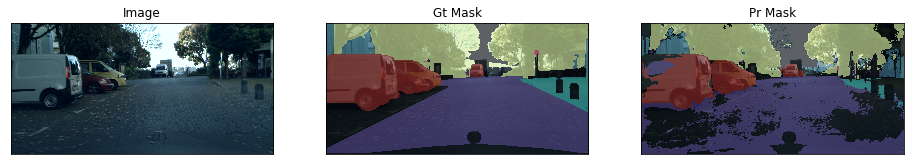

Time for forward pass: 0.2653231620788574


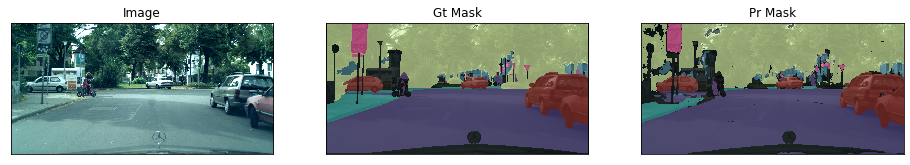

Time for forward pass: 0.2674276828765869


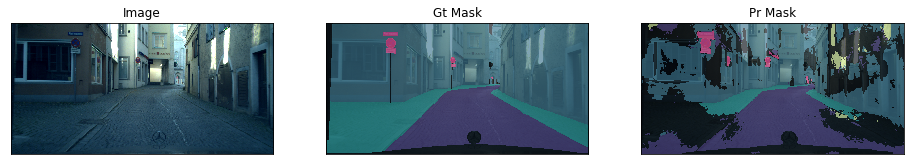

Time for forward pass: 0.25726938247680664


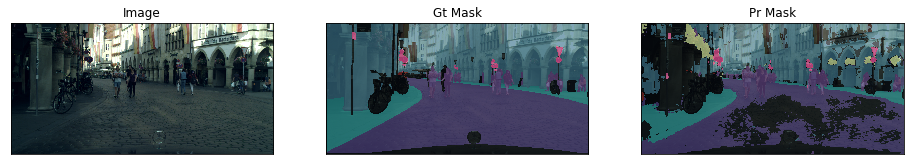

Time for forward pass: 0.2572150230407715


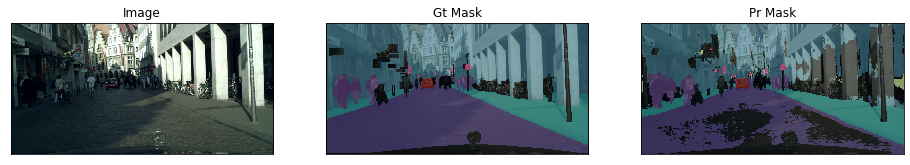

In [17]:
import time

n = 5
ids = np.random.choice(np.arange(len(valid_dataset)), size=n)

for i in ids:
    
    image, gt_layers = valid_dataset[i]
    image = np.expand_dims(image, axis=0)
    start = time.time()
    pr_layers = model.predict(image)
    end = time.time()
    print('Time for forward pass:', end-start)
    pr_mask = seglayers2mask(image, pr_layers)
    gt_mask = seglayers2mask(image, np.expand_dims(gt_layers, axis=0))
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask,
        pr_mask=pr_mask,
    )

## Test on video stream

In [17]:
preprocess_input = sm.get_preprocessing('efficientnetb3')
preprocessing = get_preprocessing(preprocess_input)
augmentation = get_validation_augmentation()
def image_preprocessing(image):
    # read data
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # apply preprocessing
    sample = augmentation(image=image)
    image = sample['image']
    sample = preprocessing(image=image)  
    img_processed = sample['image']
    return img_processed

In [18]:
import imutils
import time
from tqdm import tqdm

vs = cv2.VideoCapture('../data/videos/moscow_streets.mp4')
writer = None

# try to determine the total number of frames in the video file
try:
    prop =  cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
        else cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("[INFO] {} total frames in video".format(total))
# an error occurred while trying to determine the total
# number of frames in the video file
except:
    print("[INFO] could not determine # of frames in video")
    total = -1

FPS = []
# while(1):
for i in tqdm( range(100) ):
    # get raw frames from video stream
    ret, frame = vs.read()
    if ret == False:
        break
    # preprocess raw frames
    start = time.time()
    frame = image_preprocessing(frame)
    frame = np.expand_dims(frame, axis=0)
    # predict segmentation mask from the frame
    pr_layers = model.predict(frame)
    end = time.time()
    FPS.append(1./(end-start))
    pr_mask = seglayers2mask(frame, pr_layers)
#     print("[INFO] single frame took {:.4f} seconds".format(end-start))
    
    # check if the video writer is None
    if writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter('../data/videos/moscow_output.avi', fourcc, 30,
            (pr_mask.shape[1], pr_mask.shape[0]), True)

        # some information on processing single frame
        if total > 0:
            elap = (end - start)
            print("[INFO] single frame took {:.4f} seconds".format(elap))
            print("[INFO] estimated total time: {:.4f} [min]".format(elap * total/60.))

    # write the output frame to disk
    writer.write(pr_mask)
print("[INFO] Mean FPS {:.4f} Hz".format(np.mean(FPS)))

#     visualize(
#         image=denormalize(frame.squeeze()),
#         pr_mask=pr_mask,
#     )

  0%|          | 0/100 [00:00<?, ?it/s]

[INFO] 12911 total frames in video



  3%|▎         | 3/100 [00:03<03:45,  2.33s/it]

[INFO] single frame took 3.2644 seconds
[INFO] estimated total time: 702.4423 [min]


100%|██████████| 100/100 [00:11<00:00,  8.51it/s]

[INFO] Mean FPS 14.8910 Hz
